**Background:**
We are one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. During the COVID-19 pandemic, we are facing several different challenges and everyday we are trying to address these challenges.

We thrive on making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

**Data Description:**

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers <br> 
X1 = my order was delivered on time <br> 
X2 = contents of my order was as I expected <br> 
X3 = I ordered everything I wanted to order <br> 
X4 = I paid a good price for my order <br> 
X5 = I am satisfied with my courier <br> 
X6 = the app makes ordering easy for me <br> 

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

In [36]:
!pip install lazypredict
!pip install shap
!pip install imblearn

     -------------------------------------- 226.0/226.0 kB 3.5 MB/s eta 0:00:00
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


# Overview


1.   Exploratory data analysis and preprocessing

  *   Dataset exploration
  *   Nan values
  *   Outliers with Isolation forest (10% baseline)
  *   Features correlations matrices

2.   Classification models (80-20 split)

  *   model choice based on LazyPredict library
  *   Random state choice based on XGBoost, ExtraTreesClassifier, DecisionTreeClassifier, RandomForrestClassifier
  *   XGBoost parameters optimization with CV Grid
  *   Shap analysis of the XGBoost
  *   ExtraTreesClassifier parameters optimization with CV Grid
  *   Shap analysis of the ExtraTreesClassifier

3. Data augmentation

  *   Synthetic Minority Over-sampling Technique
  *   Downsizing the data and adjusting skewness
  *   Checking the performance on the augmented data with XGBoost and ExtraTreesClassifier

4. Feature engineering

  *   Removing less significant feature and checking performance









In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy import stats
import xgboost as xgb
from sklearn import metrics

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
df = pd.read_csv(r"C:\Users\mbajd\OneDrive\Dokumenty\apziva\Aprziva\aTDFAD59Pb7cC10I\ACME-HappinessSurvey2020.csv")

In [5]:
df.shape

(126, 7)

In [6]:
column_types = df.dtypes
column_types

Y     int64
X1    int64
X2    int64
X3    int64
X4    int64
X5    int64
X6    int64
dtype: object

In [7]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [8]:
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.00,126.00,126.00,126.00,126.00,126.00,126.00
mean,0.55,4.33,2.53,3.31,3.75,3.65,4.25
std,0.50,0.80,1.11,1.02,0.88,1.15,0.81
min,0.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,0.00,4.00,2.00,3.00,3.00,3.00,4.00
50%,1.00,5.00,3.00,3.00,4.00,4.00,4.00
75%,1.00,5.00,3.00,4.00,4.00,4.00,5.00
max,1.00,5.00,5.00,5.00,5.00,5.00,5.00


In [9]:
df.isna().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

In [10]:
target_counts = df['Y'].value_counts()
class_balance = target_counts / len(df) * 100
target_counts
#class_balance

1    69
0    57
Name: Y, dtype: int64

In [11]:
Y = df['Y']
X = df.drop('Y', axis=1)


In [12]:
numeric_columns = df.select_dtypes(include=[float, int])

# Calculate the maximum value for each column
max_values = numeric_columns.max(axis=0)

# Display the maximum values for each feature
print(max_values)

Y     1
X1    5
X2    5
X3    5
X4    5
X5    5
X6    5
dtype: int64


In [13]:
max_values = X.max(axis=0)
max_values

X1    5
X2    5
X3    5
X4    5
X5    5
X6    5
dtype: int64

In [14]:
min_values = X.min(axis=0)
min_values

X1    1
X2    1
X3    1
X4    1
X5    1
X6    1
dtype: int64

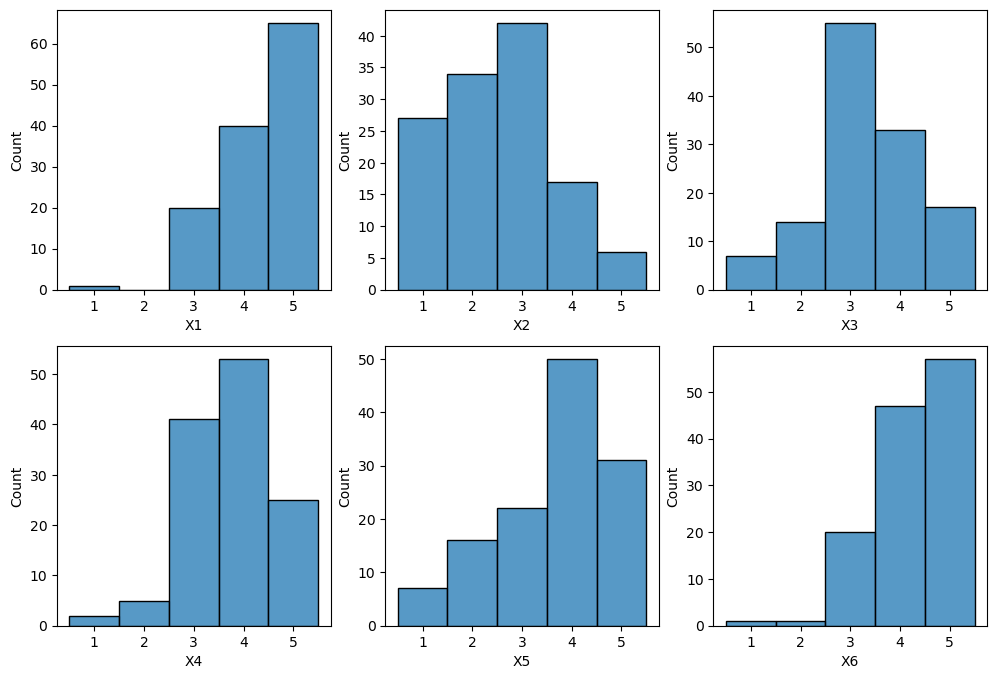

In [15]:
fig, ax = plt.subplots(2,3,figsize=(12, 8))
i = 0
for items in X.columns:
  sns.histplot(data=df, x=items, ax=ax[i // 3, i % 3], discrete=True)
  i += 1


# Outliers based on the Isolation Forest

In [16]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, contamination=0.1)
isolation_forest.fit(df)
outliers = df[isolation_forest.predict(df) == -1]
print(outliers)

     Y  X1  X2  X3  X4  X5  X6
6    0   3   1   2   2   1   3
9    0   4   4   4   2   5   5
23   1   5   1   2   5   2   4
34   1   4   1   3   1   1   4
44   1   3   1   2   4   3   5
47   0   1   1   1   3   1   4
56   0   5   1   1   5   3   5
63   0   5   5   5   2   5   5
71   0   4   5   5   5   1   3
90   0   3   4   5   4   5   4
94   0   3   1   3   2   1   2
116  1   3   4   4   5   1   3
119  1   5   5   1   1   5   1


In [17]:
# Assuming you have a variable named outliers.index
outliers_index = np.array(outliers.index)

# Reshape the outliers_index array
reshaped_index = outliers_index.reshape((-1, 1))

flat_indices = [idx[0] for idx in reshaped_index]


In [18]:
# Alternatively, you can drop the rows in place by setting the "inplace" parameter to True
df.drop(flat_indices, inplace=True)

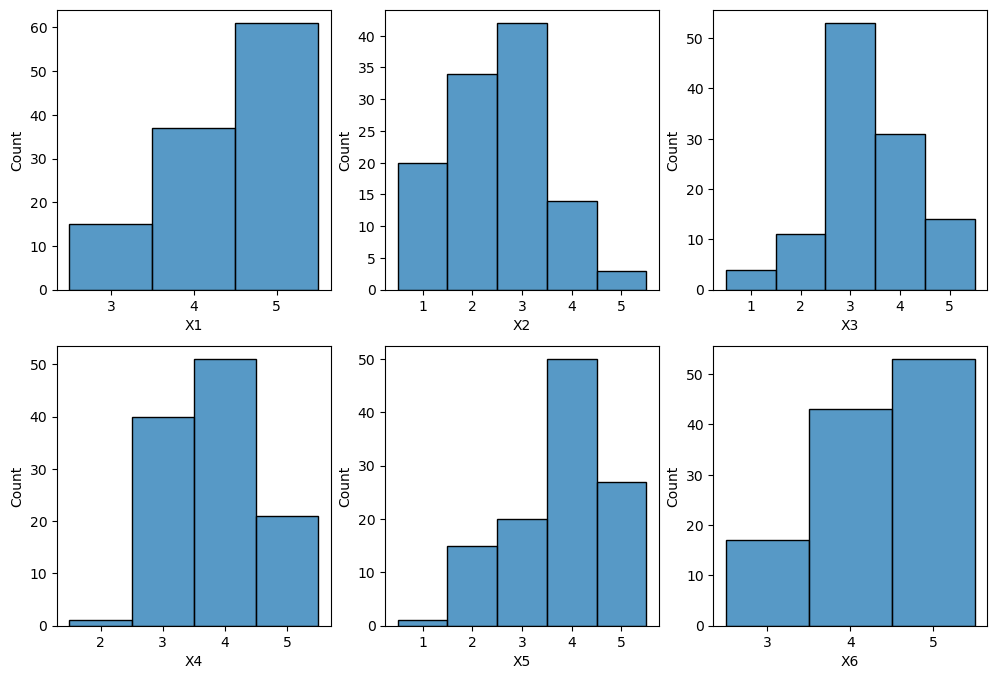

In [19]:
fig, ax = plt.subplots(2,3,figsize=(12, 8))
i = 0
for items in X.columns:
  sns.histplot(data=df, x=items, ax=ax[i // 3, i % 3], discrete=True)
  i += 1


In [20]:
Y = df['Y']
X = df.drop('Y', axis=1)


# Correlation matrix 1 (with respect to Y)

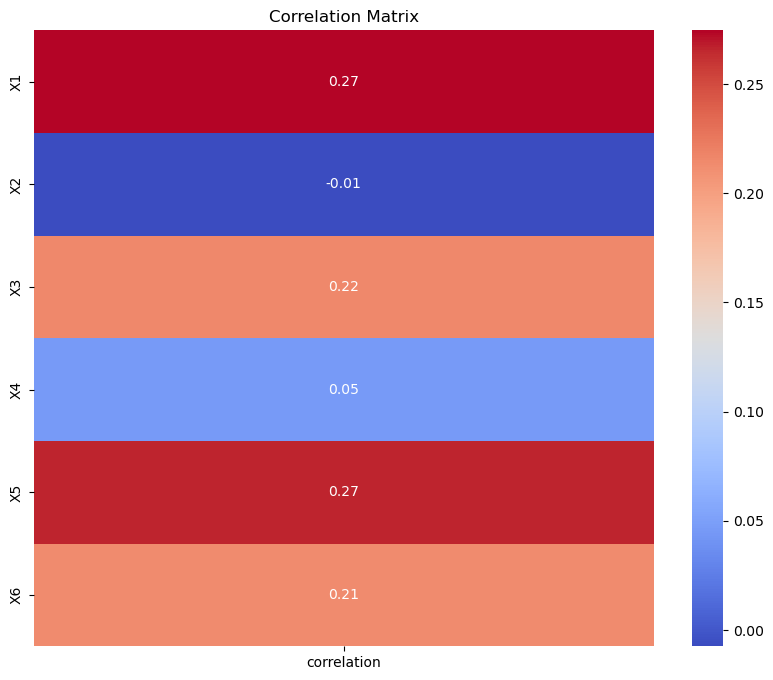

In [21]:
# Compute the correlation coefficients
correlation_matrix = pd.DataFrame(index=X.columns, columns=['correlation'])

for feature in X.columns:
    if X[feature].dtype == 'object':
        # For categorical features, compute Cramér's V
        confusion_matrix = pd.crosstab(X[feature], Y)
        chi2, _, _, _ = stats.chi2_contingency(confusion_matrix)
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        correlation = np.sqrt(phi2 / (min(confusion_matrix.shape) - 1))
    else:
        # For numerical features, compute point biserial correlation
        correlation = stats.pointbiserialr(X[feature], Y)[0]

    correlation_matrix.loc[feature, 'correlation'] = correlation

# Convert correlation values to numeric format
correlation_matrix['correlation'] = pd.to_numeric(correlation_matrix['correlation'])

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Matrix")
plt.show()

# Correlation matrix 2 (different representation)

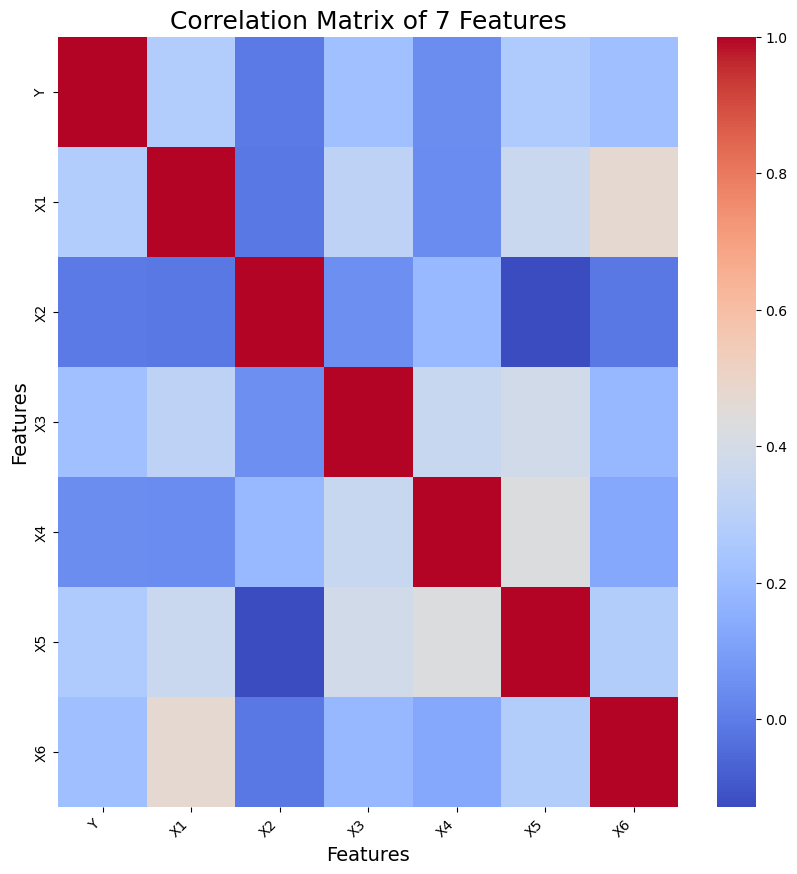

In [22]:
# Create a correlation matrix
corr_matrix = df.corr()

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 10))

# Create the heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', ax=ax)

# Set the title and axis labels
ax.set_title('Correlation Matrix of 7 Features', fontsize=18)
ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Features', fontsize=14)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

# Getting the least corelated features




In [23]:
corr_matrix = df.corrwith(df['Y'])
corr_matrix = corr_matrix.sort_values(ascending=True)
corr_matrix

X2   -0.01
X4    0.04
X3    0.18
X6    0.20
X1    0.24
X5    0.25
Y     1.00
dtype: float64

In [24]:
features = corr_matrix.index
features = features[0:5]
features

Index(['X2', 'X4', 'X3', 'X6', 'X1'], dtype='object')

# Model Performance

In [25]:
#Droping too features which are less correlated with the outcome
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)
values = (X_train_scaled.shape[1],models.iloc[0,0])
print(predictions)

100%|██████████| 29/29 [00:03<00:00,  8.48it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score   
Model                                                                           
LinearSVC                          0.74               0.73     0.73      0.74  \
RidgeClassifier                    0.74               0.73     0.73      0.74   
LinearDiscriminantAnalysis         0.74               0.73     0.73      0.74   
RandomForestClassifier             0.74               0.72     0.72      0.73   
XGBClassifier                      0.74               0.71     0.71      0.72   
LabelPropagation                   0.70               0.70     0.70      0.70   
ExtraTreeClassifier                0.70               0.70     0.70      0.70   
LabelSpreading                     0.70               0.70     0.70      0.70   
RidgeClassifierCV                  0.70               0.68     0.68      0.69   
LogisticRegression                 0.70               0.68     0.68      0.69   
BernoulliNB                 

Model accuracy on the test set: 0.5652173913043478, random state: 0
Model accuracy on the test set: 0.5652173913043478, random state: 1
Model accuracy on the test set: 0.5217391304347826, random state: 2
Model accuracy on the test set: 0.43478260869565216, random state: 3
Model accuracy on the test set: 0.4782608695652174, random state: 4
Model accuracy on the test set: 0.6086956521739131, random state: 5
Model accuracy on the test set: 0.6521739130434783, random state: 6
Model accuracy on the test set: 0.6086956521739131, random state: 7
Model accuracy on the test set: 0.7391304347826086, random state: 8
Model accuracy on the test set: 0.5217391304347826, random state: 9
Model accuracy on the test set: 0.4782608695652174, random state: 10
Model accuracy on the test set: 0.5652173913043478, random state: 11
Model accuracy on the test set: 0.4782608695652174, random state: 12
Model accuracy on the test set: 0.5652173913043478, random state: 13
Model accuracy on the test set: 0.608695652

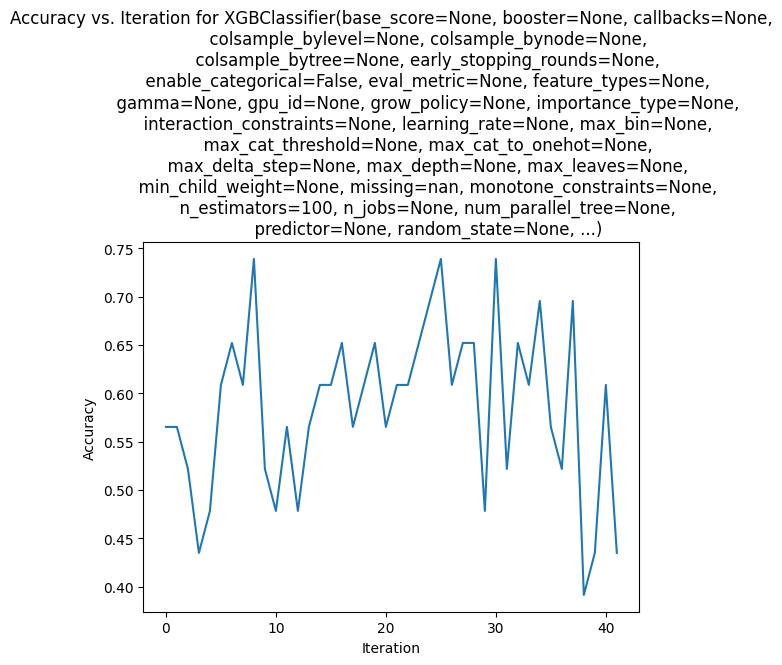

Model accuracy on the test set: 0.4782608695652174, random state: 0
Model accuracy on the test set: 0.5652173913043478, random state: 1
Model accuracy on the test set: 0.5652173913043478, random state: 2
Model accuracy on the test set: 0.5217391304347826, random state: 3
Model accuracy on the test set: 0.6086956521739131, random state: 4
Model accuracy on the test set: 0.4782608695652174, random state: 5
Model accuracy on the test set: 0.5217391304347826, random state: 6
Model accuracy on the test set: 0.6086956521739131, random state: 7
Model accuracy on the test set: 0.6956521739130435, random state: 8
Model accuracy on the test set: 0.4782608695652174, random state: 9
Model accuracy on the test set: 0.5217391304347826, random state: 10
Model accuracy on the test set: 0.5217391304347826, random state: 11
Model accuracy on the test set: 0.4782608695652174, random state: 12
Model accuracy on the test set: 0.5217391304347826, random state: 13
Model accuracy on the test set: 0.3913043478

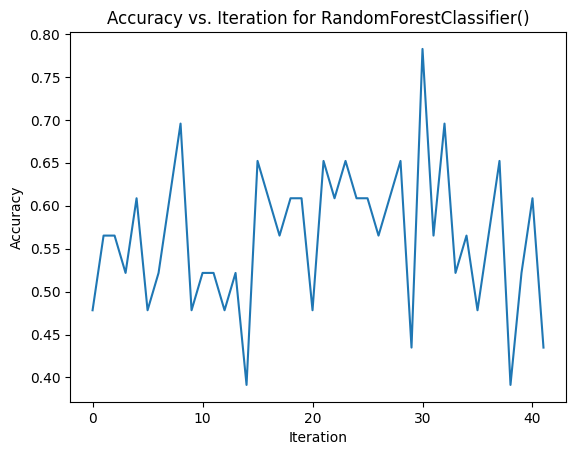

Model accuracy on the test set: 0.4782608695652174, random state: 0
Model accuracy on the test set: 0.43478260869565216, random state: 1
Model accuracy on the test set: 0.5652173913043478, random state: 2
Model accuracy on the test set: 0.5652173913043478, random state: 3
Model accuracy on the test set: 0.5652173913043478, random state: 4
Model accuracy on the test set: 0.4782608695652174, random state: 5
Model accuracy on the test set: 0.4782608695652174, random state: 6
Model accuracy on the test set: 0.5652173913043478, random state: 7
Model accuracy on the test set: 0.6521739130434783, random state: 8
Model accuracy on the test set: 0.43478260869565216, random state: 9
Model accuracy on the test set: 0.5217391304347826, random state: 10
Model accuracy on the test set: 0.5652173913043478, random state: 11
Model accuracy on the test set: 0.43478260869565216, random state: 12
Model accuracy on the test set: 0.5652173913043478, random state: 13
Model accuracy on the test set: 0.4782608

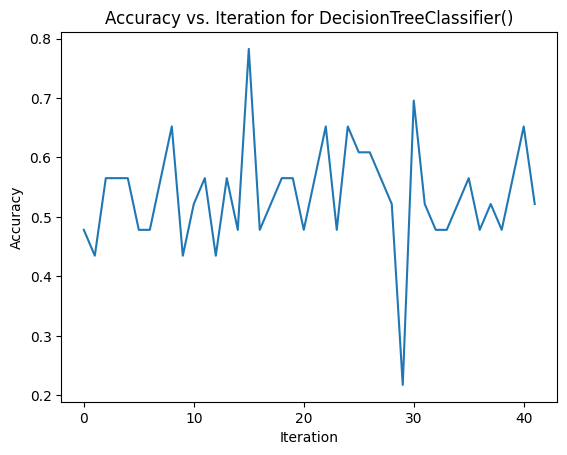

Model accuracy on the test set: 0.4782608695652174, random state: 0
Model accuracy on the test set: 0.5217391304347826, random state: 1
Model accuracy on the test set: 0.5652173913043478, random state: 2
Model accuracy on the test set: 0.4782608695652174, random state: 3
Model accuracy on the test set: 0.6086956521739131, random state: 4
Model accuracy on the test set: 0.6086956521739131, random state: 5
Model accuracy on the test set: 0.6521739130434783, random state: 6
Model accuracy on the test set: 0.5652173913043478, random state: 7
Model accuracy on the test set: 0.6956521739130435, random state: 8
Model accuracy on the test set: 0.43478260869565216, random state: 9
Model accuracy on the test set: 0.6086956521739131, random state: 10
Model accuracy on the test set: 0.4782608695652174, random state: 11
Model accuracy on the test set: 0.34782608695652173, random state: 12
Model accuracy on the test set: 0.6086956521739131, random state: 13
Model accuracy on the test set: 0.43478260

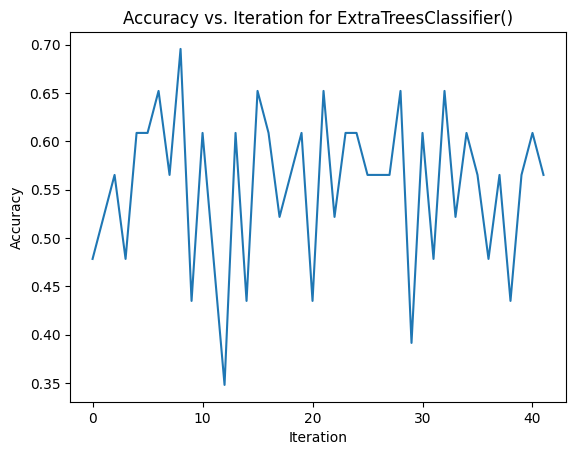

Model accuracy on the test set: 0.4782608695652174, random state: 0
Model accuracy on the test set: 0.5652173913043478, random state: 1
Model accuracy on the test set: 0.5652173913043478, random state: 2
Model accuracy on the test set: 0.5652173913043478, random state: 3
Model accuracy on the test set: 0.5652173913043478, random state: 4
Model accuracy on the test set: 0.43478260869565216, random state: 5
Model accuracy on the test set: 0.6086956521739131, random state: 6
Model accuracy on the test set: 0.5652173913043478, random state: 7
Model accuracy on the test set: 0.6956521739130435, random state: 8
Model accuracy on the test set: 0.5217391304347826, random state: 9
Model accuracy on the test set: 0.5652173913043478, random state: 10
Model accuracy on the test set: 0.5217391304347826, random state: 11
Model accuracy on the test set: 0.391304347826087, random state: 12
Model accuracy on the test set: 0.5652173913043478, random state: 13
Model accuracy on the test set: 0.4347826086

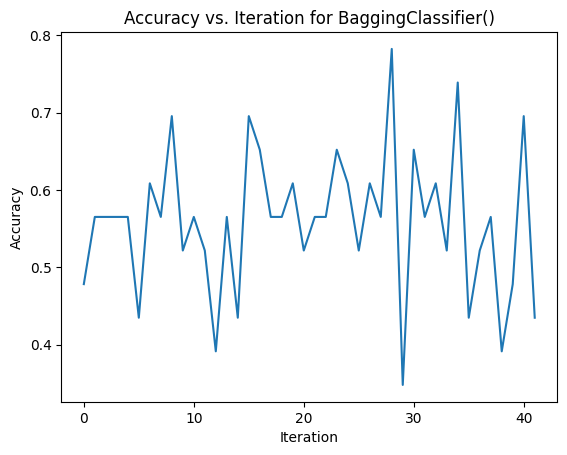

In [26]:
accuracy_max = 0
models = [xgb.XGBClassifier(), RandomForestClassifier(), DecisionTreeClassifier(), ExtraTreesClassifier(), BaggingClassifier()]

for item in models:
    accuracy_values = []
    iteration_numbers = []
    accuracy_tuple = (0, 0)  # Initialize accuracy_tuple
    i = 0
    for i in range(0, 42):
        X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i, stratify=Y)
        model = item
        model.fit(X_train_scaled, y_train)
        # Make predictions on the test set
        y_pred = model.predict(X_test_scaled)
        y_pred1 = model.predict(X_train_scaled)
        # Calculate evaluation metrics
        accuracy2 = accuracy_score(y_train, y_pred1)
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy_max < accuracy:
            accuracy_max = accuracy
            accuracy_tuple = (accuracy_max, i)
        accuracy_values.append(accuracy)
        iteration_numbers.append(i)
        print(f"Model accuracy on the test set: {accuracy}, random state: {i}")
    print(f"Highest accuracy for {item}: {accuracy_tuple[0]} (random state: {accuracy_tuple[1]})")

    # Plotting the accuracy values
    plt.plot(iteration_numbers, accuracy_values)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Iteration for {item}')
    plt.show()


# Hyperparameter optimization with CV Grid for XGBoost

In [27]:
# Define the extended parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Number of trees
    'max_depth': [None, 1, 3, 5, 7],  # Maximum depth of the trees
    'learning_rate': [0.1, 0.01, 0.001],  # Learning rate
    'subsample': [0.8, 0.9, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 1, 5],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
}

# Create an instance of the XGBoost classifier b
model = xgb.XGBClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=6)

# Fit the grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Extract the grid search results
results = grid_search.cv_results_
param_names = list(param_grid.keys())
param_values = [param_grid[name] for name in param_names]



Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


# XGBoost


In [25]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=18, stratify=Y)


# Define the parameter dictionary
params = {'colsample_bytree': 0.9,
          'gamma': 0,
          'learning_rate': 0.001,
          'max_depth': None,
          'n_estimators': 100,
          'subsample': 0.8}

# Create an instance of the XGBoost classifier
model = xgb.XGBClassifier(**params)

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred1 = model.predict(X_train_scaled)
# Calculate evaluation metrics
trained_accuracy = accuracy_score(y_train, y_pred1)
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

# Print the evaluation metrics
print(f'Model: XGBoost')
print(f'Trained data accuracy: {trained_accuracy:.4f}')   
print(f'Test data accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('---')


Model: XGBoost
Trained data accuracy: 0.7556
Test data accuracy: 0.6522
Precision: 0.6923
Recall: 0.6923
F1 Score: 0.6923
ROC AUC Score: 0.7154
---


# Shap analysis for the XGBoost

In [26]:
import shap

# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_scaled)


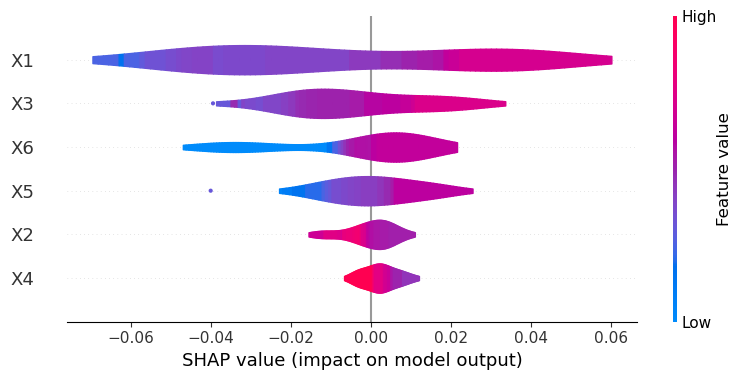

In [27]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, plot_type='violin')


In [28]:
shap.initjs()
# Force plot
sample_index = 0  # Index of the selected data point
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test_scaled.iloc[sample_index], feature_names=X.columns)

# The best parameters for Extra Trees Classifier

In [29]:
# Define the extended parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'max_depth': [None, 1, 3, 5, 7],  # Maximum depth of the trees
    'min_samples_split': [2, 4, 6],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4],  # Minimum number of samples required to be at a leaf node
}

# Create an instance of the ExtraTreesClassifier
model = ExtraTreesClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Extract the grid search results
results = grid_search.cv_results_
param_names = list(param_grid.keys())
param_values = [param_grid[name] for name in param_names]


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200}


# Extra Trees Classifier

Model: Extra Trees
Trained data accuracy: 0.8111
Test data accuracy: 0.6087
Precision: 0.6667
Recall: 0.6154
F1 Score: 0.6400
ROC AUC Score: 0.6308
---


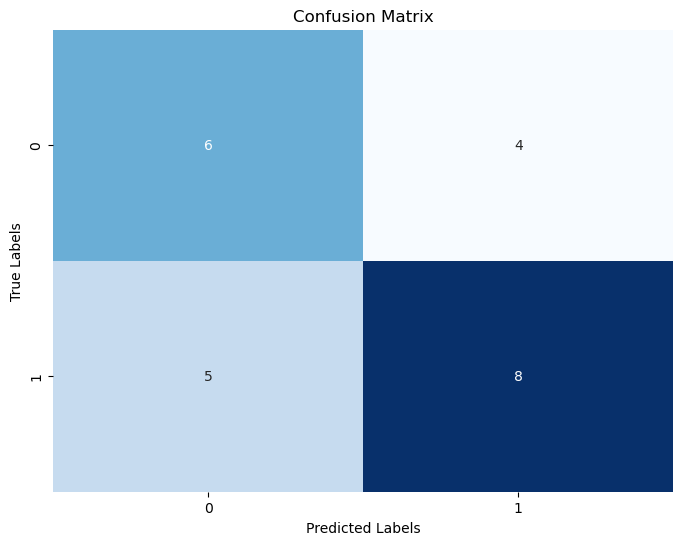

In [30]:
from sklearn.metrics import confusion_matrix


X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4, stratify=Y)


# Create an instance of the XGBoost classifie
model = ExtraTreesClassifier(n_estimators=200, max_depth=None, min_samples_leaf=4, min_samples_split=2)

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred1 = model.predict(X_train_scaled)
# Calculate evaluation metrics
trained_accuracy = accuracy_score(y_train, y_pred1)
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

# Print the evaluation metrics
print(f'Model: Extra Trees')
print(f'Trained data accuracy: {trained_accuracy:.4f}')   
print(f'Test data accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('---')


# Assuming you have the true labels 'y_true' and the predicted labels 'y_pred'
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


# Display the plot
plt.show()


Feature ranking:
1. Feature X1 (0.27989373095348064)
2. Feature X3 (0.21880079339814998)
3. Feature X5 (0.18805320290365282)
4. Feature X6 (0.132764379029415)
5. Feature X4 (0.09899753977751305)
6. Feature X2 (0.08149035393778858)


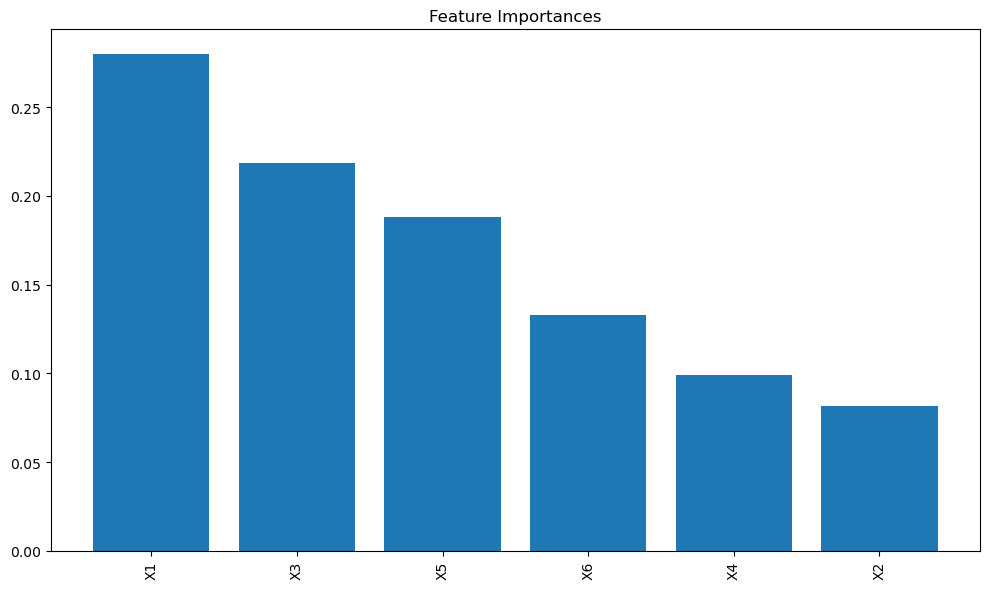

In [31]:
# Retrieve the feature importances from the trained model
importances = model.feature_importances_

# Sort the importances in descending order and get the corresponding feature indices
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {X.columns[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances using a bar chart
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

# Shap analysis for Extra Trees

In [32]:
import shap 

# Calculate SHAP values
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)


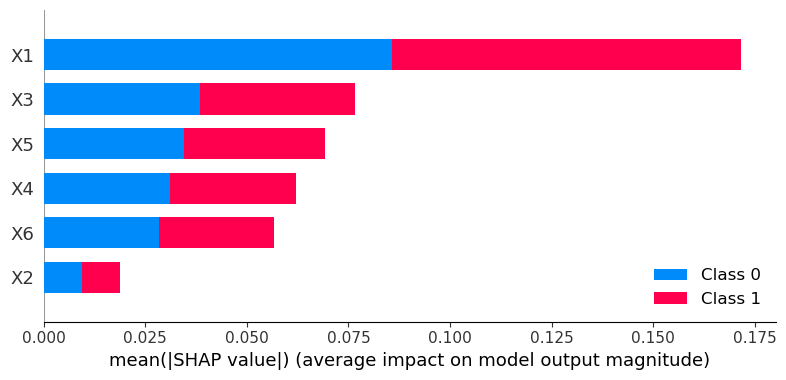

In [33]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test_scaled.columns)


# Decision Tree (just to cross check)

In [34]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21)

model = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=6)

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred1 = model.predict(X_train_scaled)
# Calculate evaluation metrics
trained_accuracy = accuracy_score(y_train, y_pred1)
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

# Print the evaluation metrics
print(f'Model: Decision Tree')
print(f'Trained data accuracy: {trained_accuracy:.4f}')   
print(f'Test data accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('---')


Model: Decision Tree
Trained data accuracy: 0.8333
Test data accuracy: 0.5217
Precision: 0.7273
Recall: 0.5000
F1 Score: 0.5926
ROC AUC Score: 0.6071
---


# SMOTE


In [40]:
from imblearn.over_sampling import SMOTE

# Create an instance of the SMOTE class
smote = SMOTE(random_state=20)

# Resample the dataset using SMOTE
X_resampled, Y_resampled = smote.fit_resample(X, Y)


# Count the class distribution before applying SMOTE
unique_classes, class_counts = np.unique(Y, return_counts=True)
print("Class distribution before SMOTE:", dict(zip(unique_classes, class_counts)))

# Count the class distribution after applying SMOTE
unique_classes_resampled, class_counts_resampled = np.unique(y_resampled, return_counts=True)
print("Class distribution after SMOTE:", dict(zip(unique_classes_resampled, class_counts_resampled)))


Class distribution before SMOTE: {0: 49, 1: 64}
Class distribution after SMOTE: {0: 64, 1: 64}


In [41]:
X_resampled

,X1,X2,X3,X4,X5,X6
0,3,3,3,4,2,4
1,3,2,3,5,4,3
2,5,3,3,3,3,5
3,5,4,3,3,3,5
4,5,4,3,3,3,5
...,...,...,...,...,...,...
123,3,4,3,3,2,3
124,5,3,2,4,3,5
125,4,1,2,4,4,5
126,3,3,3,4,3,3


Highest accuracy for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...): 0.7692307692307693 (random state: 16)


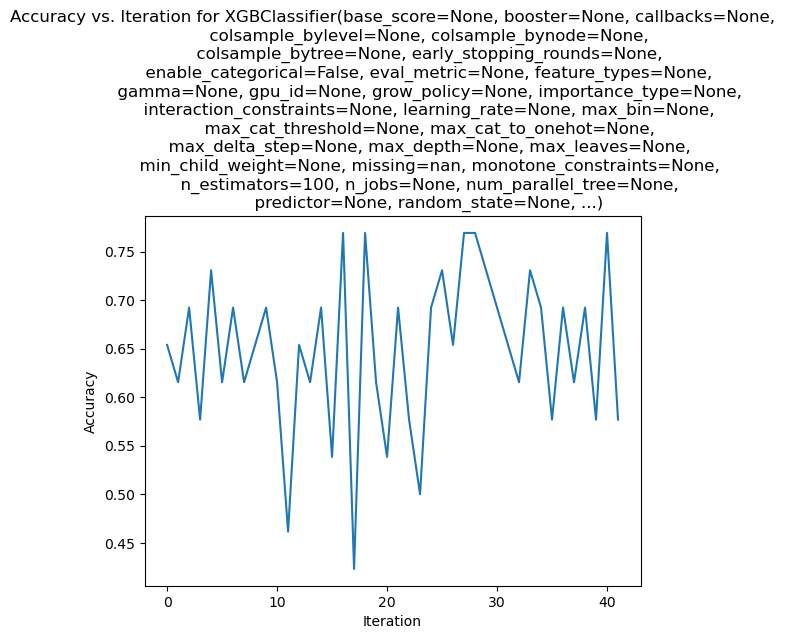

Highest accuracy for RandomForestClassifier(): 0.8076923076923077 (random state: 19)


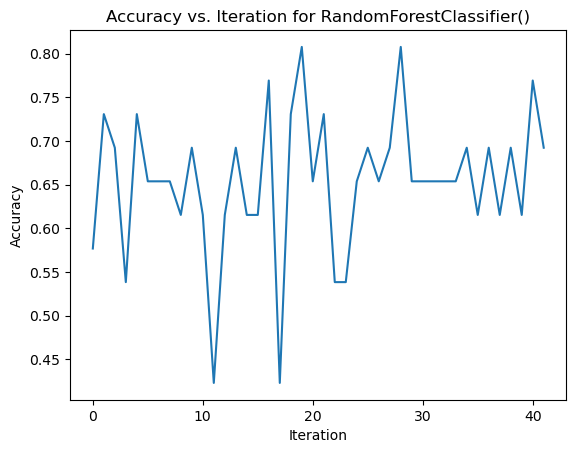

Highest accuracy for DecisionTreeClassifier(): 0 (random state: 0)


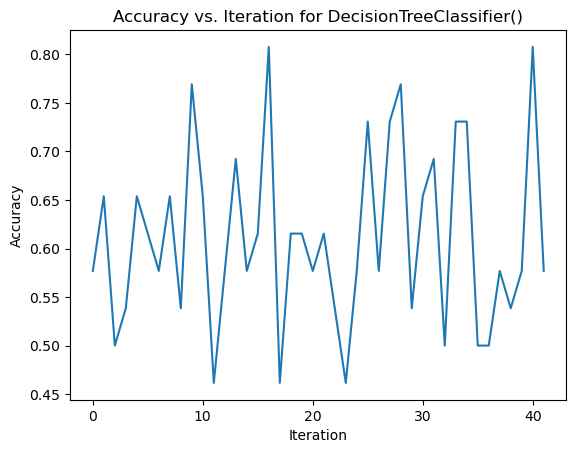

Highest accuracy for ExtraTreesClassifier(): 0 (random state: 0)


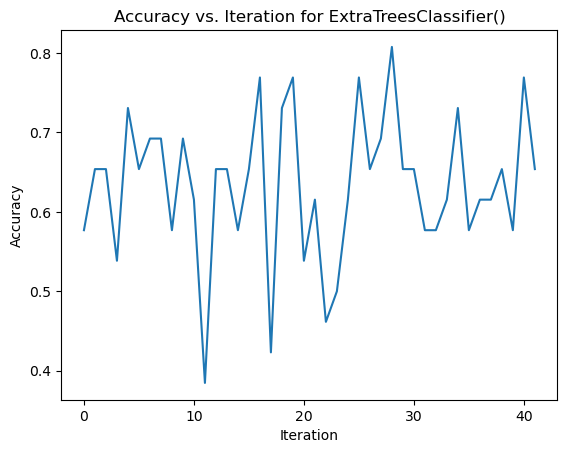

In [46]:
from sklearn.ensemble import ExtraTreesClassifier

accuracy_max = 0
models = [xgb.XGBClassifier(), RandomForestClassifier(), DecisionTreeClassifier(), ExtraTreesClassifier()]

for item in models:
    accuracy_values = []
    iteration_numbers = []
    accuracy_tuple = (0, 0)  # Initialize accuracy_tuple
    i = 0
    for i in range(0, 42):
        X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=i, stratify=Y_resampled)
        model = item
        model.fit(X_train_scaled, y_train)
        # Make predictions on the test set
        y_pred = model.predict(X_test_scaled)
        y_pred1 = model.predict(X_train_scaled)
        # Calculate evaluation metrics
        accuracy2 = accuracy_score(y_train, y_pred1)
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy_max < accuracy:
            accuracy_max = accuracy
            accuracy_tuple = (accuracy_max, i)
        accuracy_values.append(accuracy)
        iteration_numbers.append(i)
        #print(f"Model accuracy on the test set: {accuracy}, random state: {i}")
    print(f"Highest accuracy for {item}: {accuracy_tuple[0]} (random state: {accuracy_tuple[1]})")

    # Plotting the accuracy values
    plt.plot(iteration_numbers, accuracy_values)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Iteration for {item}')
    plt.show()


In [47]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=34)

In [48]:
# Define the extended parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Number of trees
    'max_depth': [None, 1, 3, 5, 7],  # Maximum depth of the trees
    'learning_rate': [0.1, 0.01, 0.001],  # Learning rate
    'subsample': [0.8, 0.9, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 1, 5],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
}

# Create an instance of the XGBoost classifier
model = xgb.XGBClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid)

# Fit the grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Extract the grid search results
results = grid_search.cv_results_
param_names = list(param_grid.keys())
param_values = [param_grid[name] for name in param_names]



Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 200, 'subsample': 1.0}


Model: XGBoost
Trained data accuracy: 0.8235
Test data accuracy: 0.7692
Precision: 0.8000
Recall: 0.6667
F1 Score: 0.7273
ROC AUC Score: 0.8452
---


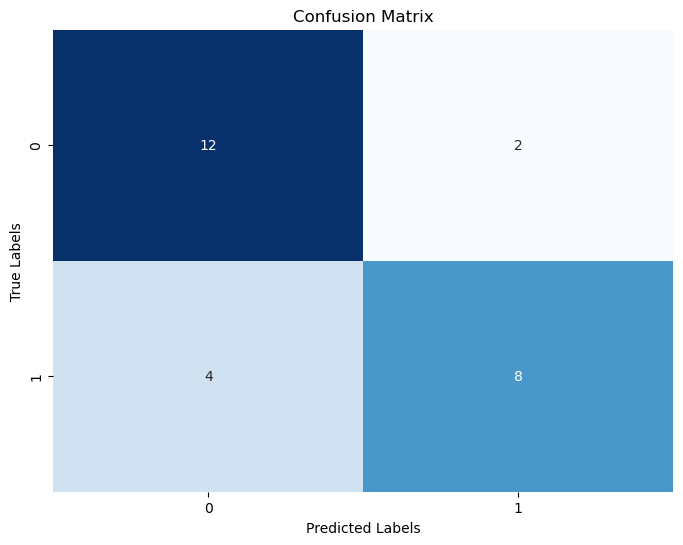

In [49]:
from sklearn.metrics import confusion_matrix


# Define the parameter dictionary
params = {'colsample_bytree': 1,
          'gamma': 0,
          'learning_rate': 0.01,
          'max_depth': None,
          'n_estimators':300,
          'subsample': 0.8}

# Create an instance of the XGBoost classifier
model = xgb.XGBClassifier(**params)

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred1 = model.predict(X_train_scaled)
# Calculate evaluation metrics
trained_accuracy = accuracy_score(y_train, y_pred1)
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

# Print the evaluation metrics
print(f'Model: XGBoost')
print(f'Trained data accuracy: {trained_accuracy:.4f}')   
print(f'Test data accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('---')

# Assuming you have the true labels 'y_true' and the predicted labels 'y_pred'
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


# Display the plot
plt.show()



# Decision Tree to cross check

In [50]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21)

model = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=3)

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred1 = model.predict(X_train_scaled)
# Calculate evaluation metrics
trained_accuracy = accuracy_score(y_train, y_pred1)
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

# Print the evaluation metrics
print(f'Model: XGBoost')
print(f'Trained data accuracy: {trained_accuracy:.4f}')   
print(f'Test data accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('---')


Model: XGBoost
Trained data accuracy: 0.9222
Test data accuracy: 0.5217
Precision: 0.8571
Recall: 0.3750
F1 Score: 0.5217
ROC AUC Score: 0.5536
---


# Downsize and skewness

In [51]:
def skewness_score(df, func):
    
    #create a copy of df
    scaledf = df.copy()
    
    for i in df.columns:
        if (df[i].agg(['skew'])[0] > 0.3) | (df[i].agg(['skew'])[0] < -0.3):
            scale = func(df[i])
            if func == boxcox:
                scaledf[i] = scale[0]
            else:
                scaledf[i] = scale

    # measure for skewness
    print(scaledf.agg(['skew']).T)
    return scaledf

In [52]:
from scipy.stats import boxcox

#box-cox transformation
boxcoxdf = skewness_score(df, boxcox)

    skew
Y  -0.27
X1 -0.38
X2  0.18
X3 -0.12
X4  0.18
X5 -0.19
X6 -0.25


In [53]:
df = boxcoxdf
Y = df['Y']
X = df.drop('Y', axis=1)
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,17.17,3,3,4,1.36,16.70
1,0,17.17,2,3,5,5.96,7.30
2,1,122.52,3,3,3,3.37,31.41
3,0,122.52,4,3,3,3.37,31.41
4,0,122.52,4,3,3,3.37,31.41


In [54]:
# Count the class distribution
class_counts = Y.value_counts()
print("Class distribution before downsizing:")
print(class_counts)

# Determine the minority and majority classes
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()

# Determine the number of instances in the minority class
minority_count = class_counts[minority_class]

# Randomly sample instances from the majority class
majority_indices = Y[Y == majority_class].index
downsampled_indices = np.random.choice(majority_indices, size=minority_count, replace=False)

# Combine the minority class instances with the downsampled majority class instances
downsampled_X = pd.concat([X.loc[Y == minority_class], X.loc[downsampled_indices]])
downsampled_y = pd.concat([Y.loc[Y == minority_class], Y.loc[downsampled_indices]])

# Count the class distribution after downsizing
downsampled_class_counts = downsampled_y.value_counts()
print("Class distribution after downsizing:")
print(downsampled_class_counts)


Class distribution before downsizing:
1    64
0    49
Name: Y, dtype: int64
Class distribution after downsizing:
0    49
1    49
Name: Y, dtype: int64


In [55]:
downsampled_X.shape

(98, 6)

Highest accuracy for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...): 0.85 (random state: 0)


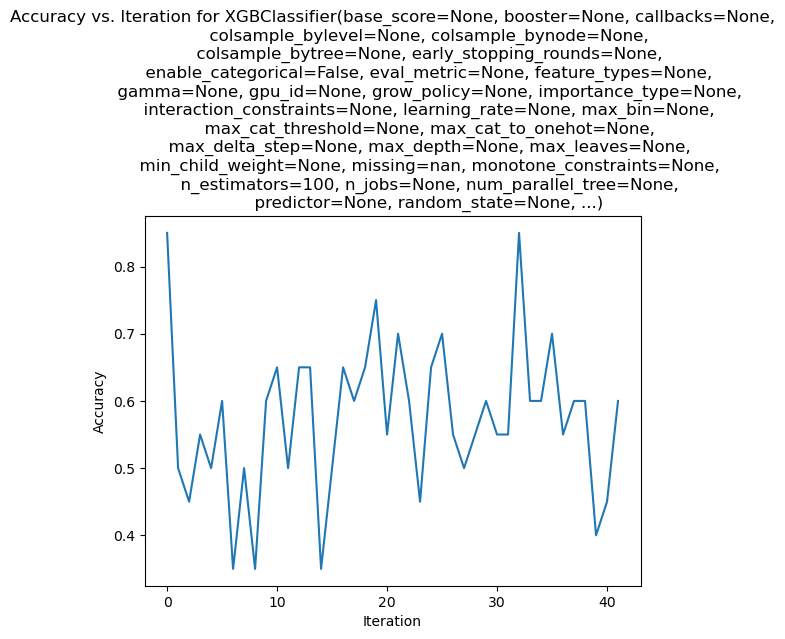

Highest accuracy for RandomForestClassifier(): 0 (random state: 0)


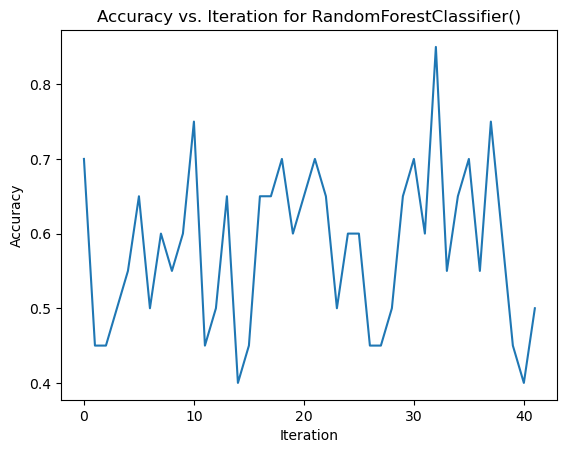

Highest accuracy for DecisionTreeClassifier(): 0 (random state: 0)


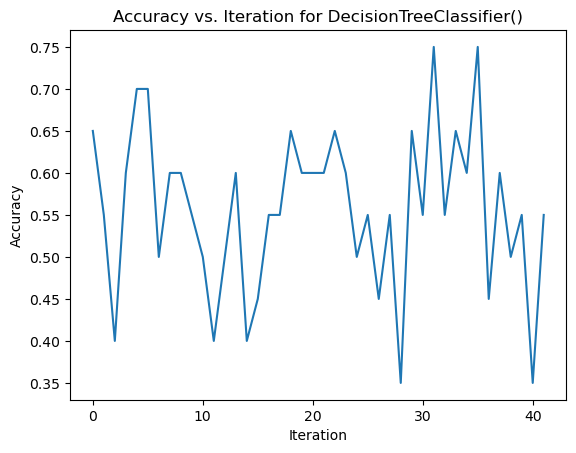

Highest accuracy for ExtraTreesClassifier(): 0 (random state: 0)


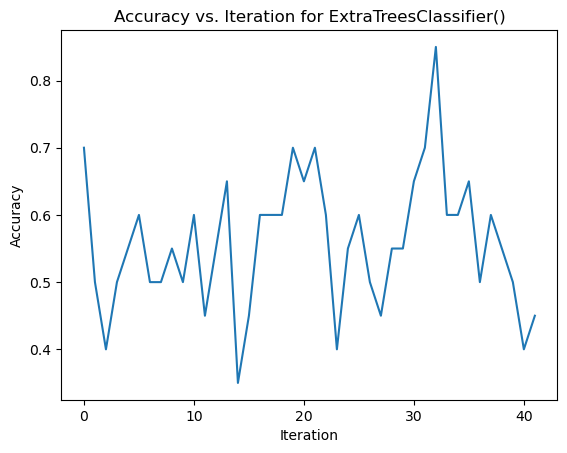

In [56]:
from sklearn.ensemble import ExtraTreesClassifier

accuracy_max = 0
models = [xgb.XGBClassifier(), RandomForestClassifier(), DecisionTreeClassifier(), ExtraTreesClassifier()]

for item in models:
    accuracy_values = []
    iteration_numbers = []
    accuracy_tuple = (0, 0)  # Initialize accuracy_tuple
    i = 0
    for i in range(0, 42):
        X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(downsampled_X, downsampled_y, test_size=0.2, random_state=i)
        model = item
        model.fit(X_train_scaled, y_train)
        # Make predictions on the test set
        y_pred = model.predict(X_test_scaled)
        y_pred1 = model.predict(X_train_scaled)
        # Calculate evaluation metrics
        accuracy2 = accuracy_score(y_train, y_pred1)
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy_max < accuracy:
            accuracy_max = accuracy
            accuracy_tuple = (accuracy_max, i)
        accuracy_values.append(accuracy)
        iteration_numbers.append(i)
        #print(f"Model accuracy on the test set: {accuracy}, random state: {i}")
    print(f"Highest accuracy for {item}: {accuracy_tuple[0]} (random state: {accuracy_tuple[1]})")

    # Plotting the accuracy values
    plt.plot(iteration_numbers, accuracy_values)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Iteration for {item}')
    plt.show()


In [75]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(downsampled_X, downsampled_y, test_size=0.2, random_state=0)

In [78]:
# Define the extended parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Number of trees
    'max_depth': [None, 1, 3, 5, 7],  # Maximum depth of the trees
    'learning_rate': [0.1, 0.01, 0.001],  # Learning rate
    'subsample': [0.8, 0.9, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 1, 5],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
}

# Create an instance of the XGBoost classifier b
model = xgb.XGBClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Extract the grid search results
results = grid_search.cv_results_
param_names = list(param_grid.keys())
param_values = [param_grid[name] for name in param_names]



Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': None, 'n_estimators': 300, 'subsample': 1.0}


In [77]:
# Define the parameter dictionary
params = {'colsample_bytree': 1,
          'gamma': 0,
          'learning_rate': 0.01,
          'max_depth': None,
          'n_estimators': 300,
          'subsample': 0.8}

# Create an instance of the XGBoost classifier
model = xgb.XGBClassifier(**params)

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred1 = model.predict(X_train_scaled)
# Calculate evaluation metrics
trained_accuracy = accuracy_score(y_train, y_pred1)
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

# Print the evaluation metrics
print(f'Model: XGBoost')
print(f'Trained data accuracy: {trained_accuracy:.4f}')   
print(f'Test data accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('---')


Model: XGBoost
Trained data accuracy: 0.7821
Test data accuracy: 0.7500
Precision: 1.0000
Recall: 0.5000
F1 Score: 0.6667
ROC AUC Score: 0.9600
---


# Checking model performance without certain feature (X2)

In [60]:
X = df.drop(['X2','Y'], axis=1)
Y = df['Y']

In [61]:
#Droping too features which are less correlated with the outcome
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)
values = (X_train_scaled.shape[1],models.iloc[0,0])
print(predictions)

100%|██████████| 29/29 [00:01<00:00, 27.03it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.65               0.67     0.67      0.65   
ExtraTreeClassifier                0.61               0.62     0.62      0.61   
LabelSpreading                     0.57               0.59     0.59      0.55   
NearestCentroid                    0.52               0.55     0.55      0.50   
ExtraTreesClassifier               0.52               0.55     0.55      0.50   
QuadraticDiscriminantAnalysis      0.52               0.54     0.54      0.51   
BernoulliNB                        0.52               0.53     0.53      0.52   
XGBClassifier                      0.52               0.53     0.53      0.52   
SGDClassifier                      0.52               0.53     0.53      0.52   
DecisionTreeClassifier             0.48               0.52     0.52      0.44   
GaussianNB                  

Model accuracy on the test set: 0.6086956521739131, random state: 0
Model accuracy on the test set: 0.6521739130434783, random state: 1
Model accuracy on the test set: 0.6086956521739131, random state: 2
Model accuracy on the test set: 0.6086956521739131, random state: 3
Model accuracy on the test set: 0.6521739130434783, random state: 4
Model accuracy on the test set: 0.5652173913043478, random state: 5
Model accuracy on the test set: 0.6956521739130435, random state: 6
Model accuracy on the test set: 0.6086956521739131, random state: 7
Model accuracy on the test set: 0.6086956521739131, random state: 8
Model accuracy on the test set: 0.6521739130434783, random state: 9
Model accuracy on the test set: 0.4782608695652174, random state: 10
Model accuracy on the test set: 0.5652173913043478, random state: 11
Model accuracy on the test set: 0.5217391304347826, random state: 12
Model accuracy on the test set: 0.6956521739130435, random state: 13
Model accuracy on the test set: 0.7391304347

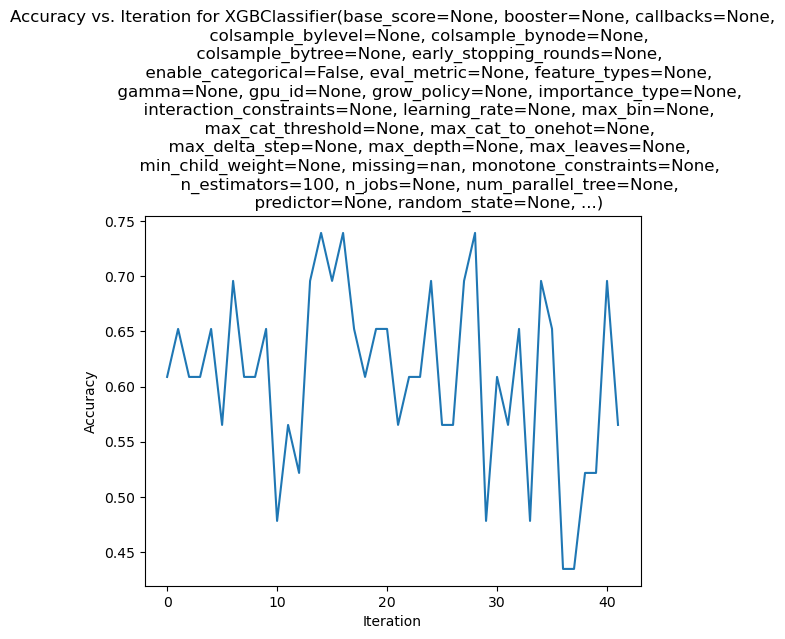

Model accuracy on the test set: 0.6521739130434783, random state: 0
Model accuracy on the test set: 0.6521739130434783, random state: 1
Model accuracy on the test set: 0.6086956521739131, random state: 2
Model accuracy on the test set: 0.6521739130434783, random state: 3
Model accuracy on the test set: 0.6521739130434783, random state: 4
Model accuracy on the test set: 0.5652173913043478, random state: 5
Model accuracy on the test set: 0.6086956521739131, random state: 6
Model accuracy on the test set: 0.6521739130434783, random state: 7
Model accuracy on the test set: 0.6521739130434783, random state: 8
Model accuracy on the test set: 0.6086956521739131, random state: 9
Model accuracy on the test set: 0.43478260869565216, random state: 10
Model accuracy on the test set: 0.5217391304347826, random state: 11
Model accuracy on the test set: 0.4782608695652174, random state: 12
Model accuracy on the test set: 0.8260869565217391, random state: 13
Model accuracy on the test set: 0.739130434

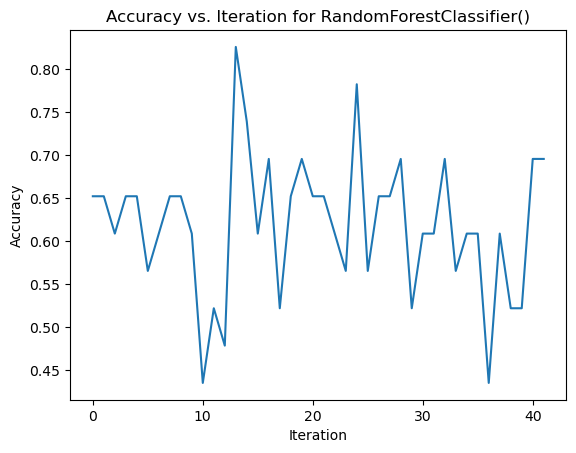

Model accuracy on the test set: 0.6521739130434783, random state: 0
Model accuracy on the test set: 0.5652173913043478, random state: 1
Model accuracy on the test set: 0.6086956521739131, random state: 2
Model accuracy on the test set: 0.6086956521739131, random state: 3
Model accuracy on the test set: 0.6956521739130435, random state: 4
Model accuracy on the test set: 0.6086956521739131, random state: 5
Model accuracy on the test set: 0.6521739130434783, random state: 6
Model accuracy on the test set: 0.6521739130434783, random state: 7
Model accuracy on the test set: 0.6521739130434783, random state: 8
Model accuracy on the test set: 0.5652173913043478, random state: 9
Model accuracy on the test set: 0.43478260869565216, random state: 10
Model accuracy on the test set: 0.5652173913043478, random state: 11
Model accuracy on the test set: 0.6521739130434783, random state: 12
Model accuracy on the test set: 0.6956521739130435, random state: 13
Model accuracy on the test set: 0.695652173

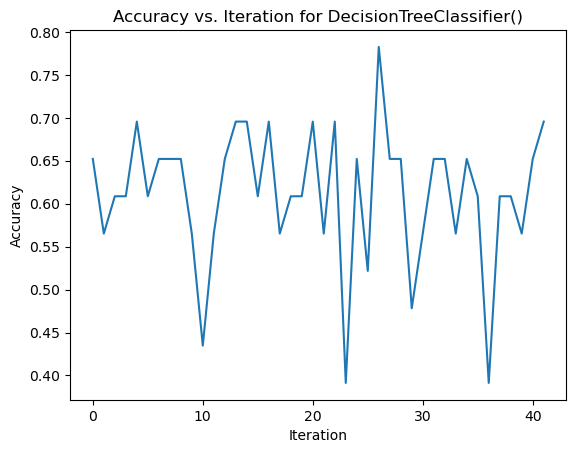

Model accuracy on the test set: 0.6521739130434783, random state: 0
Model accuracy on the test set: 0.6521739130434783, random state: 1
Model accuracy on the test set: 0.6086956521739131, random state: 2
Model accuracy on the test set: 0.6521739130434783, random state: 3
Model accuracy on the test set: 0.6521739130434783, random state: 4
Model accuracy on the test set: 0.5652173913043478, random state: 5
Model accuracy on the test set: 0.6956521739130435, random state: 6
Model accuracy on the test set: 0.6521739130434783, random state: 7
Model accuracy on the test set: 0.6086956521739131, random state: 8
Model accuracy on the test set: 0.6956521739130435, random state: 9
Model accuracy on the test set: 0.4782608695652174, random state: 10
Model accuracy on the test set: 0.4782608695652174, random state: 11
Model accuracy on the test set: 0.4782608695652174, random state: 12
Model accuracy on the test set: 0.7391304347826086, random state: 13
Model accuracy on the test set: 0.6956521739

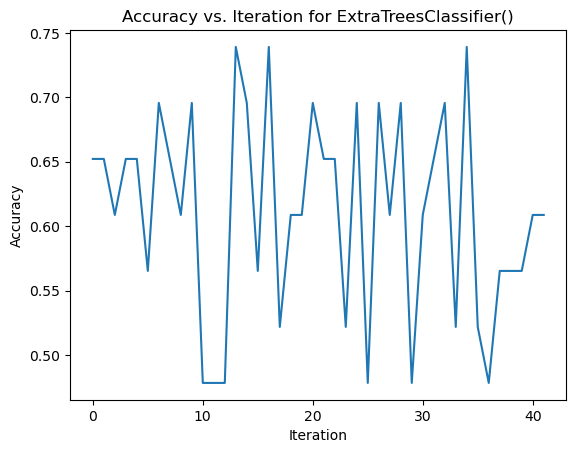

In [62]:
from sklearn.ensemble import ExtraTreesClassifier

accuracy_max = 0
models = [xgb.XGBClassifier(), RandomForestClassifier(), DecisionTreeClassifier(), ExtraTreesClassifier()]

for item in models:
    accuracy_values = []
    iteration_numbers = []
    accuracy_tuple = (0, 0)  # Initialize accuracy_tuple
    i = 0
    for i in range(0, 42):
        X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i, stratify=Y)
        model = item
        model.fit(X_train_scaled, y_train)
        # Make predictions on the test set
        y_pred = model.predict(X_test_scaled)
        y_pred1 = model.predict(X_train_scaled)
        # Calculate evaluation metrics
        accuracy2 = accuracy_score(y_train, y_pred1)
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy_max < accuracy:
            accuracy_max = accuracy
            accuracy_tuple = (accuracy_max, i)
        accuracy_values.append(accuracy)
        iteration_numbers.append(i)
        print(f"Model accuracy on the test set: {accuracy}, random state: {i}")
    print(f"Highest accuracy for {item}: {accuracy_tuple[0]} (random state: {accuracy_tuple[1]})")

    # Plotting the accuracy values
    plt.plot(iteration_numbers, accuracy_values)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Iteration for {item}')
    plt.show()


In [63]:
# Define the extended parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'max_depth': [None, 1, 3, 5, 7],  # Maximum depth of the trees
    'min_samples_split': [2, 4, 6],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4],  # Minimum number of samples required to be at a leaf node
}

# Create an instance of the ExtraTreesClassifier
model = ExtraTreesClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Extract the grid search results
results = grid_search.cv_results_
param_names = list(param_grid.keys())
param_values = [param_grid[name] for name in param_names]


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}


Model: Extra Trees
Trained data accuracy: 0.8444
Test data accuracy: 0.6957
Precision: 0.8000
Recall: 0.6154
F1 Score: 0.6957
ROC AUC Score: 0.6962
---


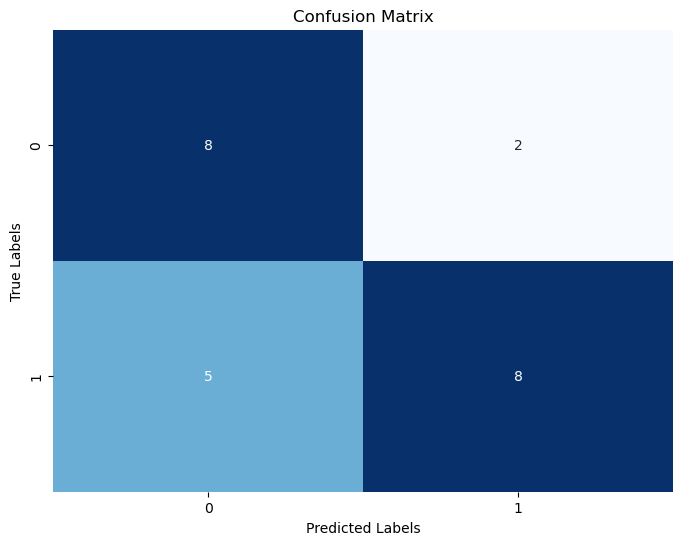

In [64]:
from sklearn.metrics import confusion_matrix


X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=28, stratify=Y)


# Create an instance of the XGBoost classifie
model = ExtraTreesClassifier(n_estimators=300, max_depth=None, min_samples_leaf=2, min_samples_split=4)

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred1 = model.predict(X_train_scaled)
# Calculate evaluation metrics
trained_accuracy = accuracy_score(y_train, y_pred1)
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

# Print the evaluation metrics
print(f'Model: Extra Trees')
print(f'Trained data accuracy: {trained_accuracy:.4f}')   
print(f'Test data accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('---')


# Assuming you have the true labels 'y_true' and the predicted labels 'y_pred'
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


# Display the plot
plt.show()
